<a href="https://colab.research.google.com/drive/1fvDBaa6-qc6ggwK37cQe7JZN1fqGhqjG#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network (DNN)



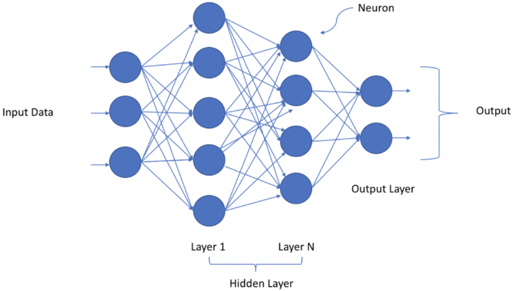

## 1. Load dataset

## 2. Import python libraries and define util functions

In [1]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_percentage_error, pearson_corrcoef
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss, plot_rmse, plot_mape

In [2]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data


In [3]:
''' load data '''
src = os.path.join(data_path, 'data_500')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (500, 56, 56)
Y.shape: (500,)


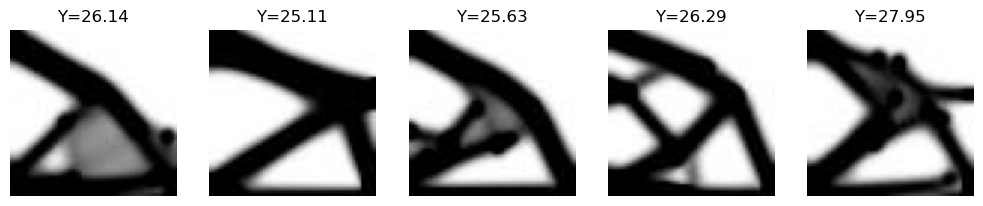

In [4]:
# check images
nplot = 5
idx = np.random.randint(1, 500, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

In [5]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# normalization (Y: 0~1)
scaler = MinMaxScaler()
Y_tr = scaler.fit_transform(Y_tr.reshape(-1,1)) # (400,) -> (400, 1)
Y_ts = scaler.transform(Y_ts.reshape(-1,1))


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

X_tr = X_tr.unsqueeze(1).to(device) # (400, 56, 56) -> (400, 1, 56, 56) : channel 추가
X_ts = X_ts.unsqueeze(1).to(device)
Y_tr = Y_tr.to(device)
Y_ts = Y_ts.to(device)

print(X_tr.size(), X_ts.size())
print(Y_tr.size(), Y_ts.size())

(400, 56, 56) (100, 56, 56) (400,) (100,)
torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


## 5. Set to model architecture

In [ ]:
''' model '''
class DNN(nn.Module):
    def __init__(self, fc_fts, sigmoid=True):
        super(DNN, self).__init__()

        self.flatten = nn.Flatten()

        self.fcs = nn.ModuleList()
        in_ft = fc_fts[0]

        for i in range(len(fc_fts)-2): # dropout, relu o
            out_ft = fc_fts[i+1]
            self.fcs.append(nn.Linear(in_ft, out_ft))
            self.fcs.append(nn.Dropout(0.3))
            self.fcs.append(nn.ReLU())
            in_ft = out_ft

        out_ft = fc_fts[-1] # dropout, relu x
        self.fcs.append(nn.Linear(in_ft, out_ft))

        if sigmoid:
            self.fcs.append(nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.fcs:
            x = layer(x)

        return x

In [7]:
# ''' model '''
# # module
# class Block(nn.Module):
#     def __init__(self, in_channels, out_channels, p=0.5):
#         super(Block, self).__init__()

#         self.fc = nn.Linear(in_channels, out_channels)
#         self.dropout = nn.Dropout(p=p)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.fc(x)
#         x = self.dropout(x)
#         x = self.relu(x)

#         return x

# # model
# class DNN(nn.Module):
#     def __init__(self, output_sigmoid=True):
#         super(DNN, self).__init__()

#         self.flatten = nn.Flatten()

#         layers = [
#             Block(56*56, 1024, p=0.2),
#             Block(1024, 512, p=0.2),
#             Block(512, 256, p=0.2),
#             Block(256, 256, p=0.2),
#             Block(256, 256, p=0.2),
#             nn.Linear(256, 1)
#         ]
#         if output_sigmoid:
#             layers.append(nn.Sigmoid())

#         self.fcs = nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.fcs(x)
        
#         return x

## 6. (Optional) Set model hyperparameters

In [8]:
dnn = DNN(fc_fts=[56*56, 1024, 512, 256, 256, 1], sigmoid=True).to(device)

summary(dnn, (1, 56, 56))  # input shape: (channels, height, width)
dnn

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3136]               0
            Linear-2                 [-1, 1024]       3,212,288
           Dropout-3                 [-1, 1024]               0
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
           Dropout-6                  [-1, 512]               0
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
           Dropout-9                  [-1, 256]               0
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 256]          65,792
          Dropout-12                  [-1, 256]               0
             ReLU-13                  [-1, 256]               0
           Linear-14                   

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcs): ModuleList(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [9]:
''' hyper params '''
num_epochs = 200
batch_size = 32
learning_rate = 1e-3

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=dnn.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

In [10]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, Y_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
''' train '''
loss_tr_hist = []
rmse_tr_hist = []
mape_tr_hist = []

loss_val_hist = []
rmse_val_hist = []
mape_val_hist = []

for epoch in range(num_epochs):

    # training
    dnn.train()
    total_loss = 0.0
    rmse_tr = 0.0
    mape_tr = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        output = dnn(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # inverse transformation (for calc metrics)
        output = output.cpu().detach().numpy().reshape(1,-1)
        output = scaler.inverse_transform(output)
        output = torch.from_numpy(output).clone().detach()
        
        y = y.cpu().detach().numpy().reshape(1,-1)
        y = scaler.inverse_transform(y)
        y = torch.from_numpy(y).clone().detach()

        rmse_tr += mean_squared_error(output, y, squared=False).item() # False=RMSE, True=MSE
        mape_tr += 100*mean_absolute_percentage_error(output, y).item()

    avg_loss_tr = total_loss / len(train_loader)
    avg_rmse_tr = rmse_tr / len(train_loader)
    avg_mape_tr = mape_tr / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss_tr)
    rmse_tr_hist.append(avg_rmse_tr)
    mape_tr_hist.append(avg_mape_tr)


    # validation
    dnn.eval()
    with torch.no_grad():
        outputs = dnn(X_ts)
        loss_val = criterion(outputs, Y_ts).item()

        # inverse transformation
        outputs = outputs.cpu().detach().numpy().reshape(1,-1)
        outputs = scaler.inverse_transform(outputs)
        outputs = torch.from_numpy(outputs).clone().detach().reshape(1,-1)

        Y  = Y_ts.cpu().detach().numpy().reshape(1,-1)
        Y  = scaler.inverse_transform(Y)
        Y  = torch.from_numpy(Y).clone().detach().reshape(1,-1)

        rmse_val = mean_squared_error(outputs, Y, squared=False).item()
        mape_val = mean_absolute_percentage_error(outputs, Y).item() * 100

    # history
    loss_val_hist.append(loss_val)
    rmse_val_hist.append(rmse_val)
    mape_val_hist.append(mape_val)
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Train loss: {avg_loss_tr:.4f}, Val loss: {loss_val:.4f}')

# scheduler.step()

Epoch [  1/200], Train loss: 0.0795, Val loss: 0.0698
Epoch [  2/200], Train loss: 0.0689, Val loss: 0.0566
Epoch [  3/200], Train loss: 0.0580, Val loss: 0.0396
Epoch [  4/200], Train loss: 0.0408, Val loss: 0.0325
Epoch [  5/200], Train loss: 0.0340, Val loss: 0.0268
Epoch [  6/200], Train loss: 0.0283, Val loss: 0.0248
Epoch [  7/200], Train loss: 0.0263, Val loss: 0.0288
Epoch [  8/200], Train loss: 0.0221, Val loss: 0.0269
Epoch [  9/200], Train loss: 0.0228, Val loss: 0.0159
Epoch [ 10/200], Train loss: 0.0184, Val loss: 0.0174
Epoch [ 11/200], Train loss: 0.0181, Val loss: 0.0130
Epoch [ 12/200], Train loss: 0.0135, Val loss: 0.0107
Epoch [ 13/200], Train loss: 0.0131, Val loss: 0.0146
Epoch [ 14/200], Train loss: 0.0117, Val loss: 0.0107
Epoch [ 15/200], Train loss: 0.0121, Val loss: 0.0088
Epoch [ 16/200], Train loss: 0.0095, Val loss: 0.0163
Epoch [ 17/200], Train loss: 0.0145, Val loss: 0.0158
Epoch [ 18/200], Train loss: 0.0118, Val loss: 0.0092
Epoch [ 19/200], Train loss:

## 7. Visualize learning history

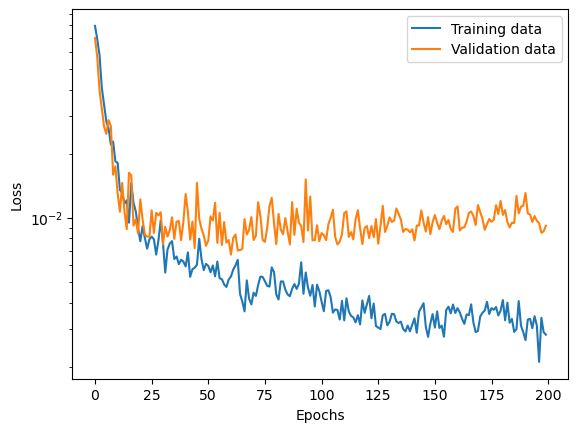

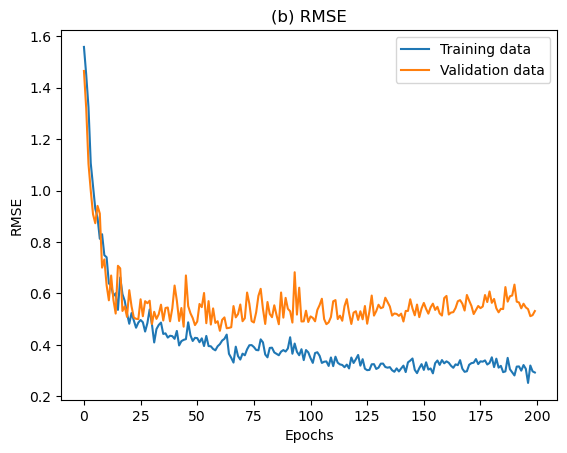

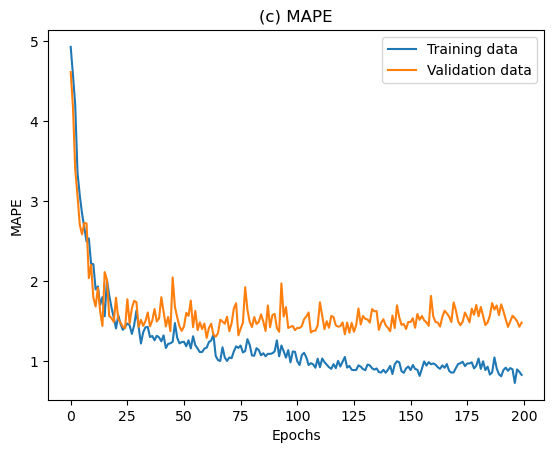

In [12]:
# graph visualization
plot_loss(loss_tr_hist, loss_val_hist, '(a) Loss')
plot_rmse(rmse_tr_hist, rmse_val_hist, '(b) RMSE')
plot_mape(mape_tr_hist, mape_val_hist, '(c) MAPE')

## 8. Evaluate model performance

valid RMSE :  0.0958
valid MAPE :  0.1751
valid R2 :  0.9382


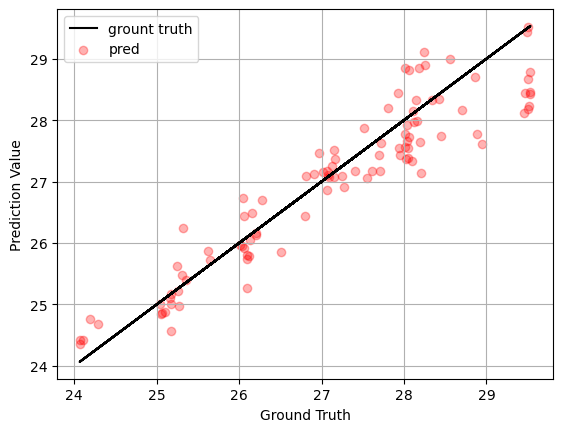

In [13]:
''' evaluation '''
dnn.eval()
Y_pred = dnn(X_ts)

# RMSE, MAPE, R2 metrics
rmse = mean_squared_error(Y_pred, Y_ts, squared=False).item()
mape = mean_absolute_percentage_error(Y_ts, Y_pred).item()
r2 = pearson_corrcoef(Y_pred, Y_ts).item()


# inverse transform
_Y_pred = Y_pred.cpu().detach()
_Y_ts = Y_ts.cpu()

_Y_pred = scaler.inverse_transform(_Y_pred)
_Y_ts = scaler.inverse_transform(_Y_ts)


# plot
plt.plot(_Y_ts, _Y_ts, c='black')
plt.scatter(_Y_ts, _Y_pred, alpha=0.3, color='red')

plt.legend(['grount truth','pred'])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid()

print("valid RMSE : " , np.round(rmse,4))
print("valid MAPE : " , np.round(mape,4))
print("valid R2 : " , np.round(r2,4))